In [1]:
import numpy as np 
import os
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import math
from matplotlib import pyplot as plt

import sys
sys.path.append('../utils')

from text.utils import save_text_state, load_text_state, build_text_state, load_books
from model.utils import get_device, load_model_state, save_model_state, build_model_state

from text_model import TextModel, get_loss_function

### Verify if CUDA is available

In [2]:
device = get_device()
print(device)

cuda


### Loading word vectors and training/validation dataset

In [3]:
LOAD_CHECKPOINTS = True

CHECKPOINT_BASE = 'checkpoints'
DATASET_FILENAME = '../datasets/books.pk'
AUTHOR = 'Friedrich Nietzsche'

VAL_PARTITION = 0.3 
SENTENCE_LENGTH = 27
BATCH_SIZE = 8

In [4]:
# Try loading dataset, if it doesn't exists then creates it
try:
    if not LOAD_CHECKPOINTS:
        print('New training required')
        raise Error('New training required')
        
    vocab, train_dataset, test_dataset = load_text_state(os.path.join(CHECKPOINT_BASE, AUTHOR + '_text.pk'))    
    print('Checkpoint loaded')
except:
    books = load_books(DATASET_FILENAME, author=AUTHOR)
    vocab, train_dataset, test_dataset = build_text_state(books, SENTENCE_LENGTH, VAL_PARTITION, vocab_name=AUTHOR)  
    print('No checkpoint found. New partition.')
    print('Included books:')
    for book in books:
        print('\t', book)

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE)

No checkpoint found. New partition.
Included books:
	 Name: The antichrist   Author: Friedrich Nietzsche
	 Name: Thus spake Zarathustra   Author: Friedrich Nietzsche


In [5]:
save_text_state(os.path.join(CHECKPOINT_BASE, AUTHOR + '_text.pk'), vocab, train_dataset, test_dataset) 

### Loading components

In [6]:
VOCAB_SIZE = len(vocab)

LEARNING_RATE = 1e-4
BETA_1 = 0.1
BETA_2 = 0.999
EPOCHS = 50
NUM_HEADS = 8
ENCODER_LAYERS = 1
DECODER_LAYERS = 1
EMBEDDING_SIZE = 512
FF_DIM = 1024
DROPOUT=0.1
STEP_LR_DECAY = 15
LR_FACTOR_DECAY = 0.5

In [7]:
model = TextModel(
    vocab_size=VOCAB_SIZE,
    embedding_size=EMBEDDING_SIZE, 
    num_heads=NUM_HEADS, 
    encoder_layers=ENCODER_LAYERS, 
    decoder_layers=DECODER_LAYERS, 
    dim_feedforward=FF_DIM,
    dropout=DROPOUT
)

optimizer = torch.optim.Adam(
    list(model.parameters()), 
    lr=LEARNING_RATE,
    betas=(BETA_1, BETA_2)
)

loss_fn = get_loss_function()
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=STEP_LR_DECAY, gamma=LR_FACTOR_DECAY)

In [8]:
try:
    if not LOAD_CHECKPOINTS:
        print('New training required')
        raise Error('New training required')
        
    model, optimizer, last_epoch, train_loss_history, val_loss_history, best_val_loss = load_model_state(
        os.path.join(CHECKPOINT_BASE, AUTHOR + '_best.pt'), 
        model, 
        optimizer
    )
    
    for state in optimizer.state.values():
        for k, v in state.items():
            if isinstance(v, torch.Tensor):
                state[k] = v.to(device)

    print('Checkpoint loaded')
    
except:
    last_epoch, train_loss_history, val_loss_history, best_val_loss = build_model_state()
    print('No checkpoints found. New training.')
    pass

model = model.to(device)


No checkpoints found. New training.


### Training and validation

In [9]:
def train_step(transformer, loss_fn, optimizer, batch):
    transformer.train()

    transformer.zero_grad()
    optimizer.zero_grad()

    decodings = transformer(batch[:,1:], batch[:,:-1])
    
    loss = loss_fn(batch[:,1:], decodings)
    loss.backward()
    optimizer.step()
    return loss.item()    

In [10]:
def val_step(transformer, loss_fn, batch):
    transformer.eval()
    
    with torch.no_grad():
        decodings = transformer(batch[:,1:], batch[:,:-1])
        loss = loss_fn(batch[:,1:], decodings)

        return loss.item(), decodings

In [11]:
# Define steps where examples will be sampled 
test_examples = iter(test_dataloader)

# For EPOCHS
for epoch in range(last_epoch + 1, EPOCHS + last_epoch):
    
    print('*************************** EPOCH {} ***************************'.format(epoch))

    # Restart train dataset
    examples = iter(train_dataloader)

    # Progress bar for training dataset
    progress_bar = tqdm(range(len(train_dataloader)))
    train_loss = 0

    # For all data in training dataset
    # Training
    for batch_idx in progress_bar:

        # Add train loss to progress bar
        progress_bar.set_postfix({
            'tr_loss': train_loss / (batch_idx + 1), 
            'lr': scheduler.get_lr()[0]
        })

        # Train step
        example = next(examples).to(device)
        train_loss += train_step(model, loss_fn, optimizer, example)


        if batch_idx == 0:
            try:
                example = next(test_examples).to(device)
            except:
                test_examples = iter(test_dataloader)
                example = next(test_examples).to(device)

            with torch.no_grad():
                _, decodings = val_step(model, loss_fn, example)
                decodings = torch.argmax(decodings[0], dim=-1).cpu().numpy()

            print('\nReal: {}'.format(vocab.to_words(example[0][1:].cpu().numpy())))
            print('Decoded: {}'.format(vocab.to_words(decodings)))

    # Validation
    val_examples = iter(test_dataloader)
    progress_bar = tqdm(range(len(test_dataloader)))
    val_loss = 0

    for batch_idx in progress_bar:
        progress_bar.set_postfix({
            'val_loss': val_loss / (batch_idx + 1)
        })
        
        example = next(val_examples).to(device)
        
        with torch.no_grad():
            val_loss += val_step(model, loss_fn, example)[0]
    
    # Save losses in history
    train_loss_history.append(train_loss / len(train_dataloader))
    val_loss_history.append(val_loss / len(test_dataloader))
    
    # If this model is best than other
    if best_val_loss is None or val_loss < best_val_loss:
        best_val_loss = val_loss
        
        save_model_state(
            os.path.join(CHECKPOINT_BASE, AUTHOR + '_best.pt'), 
            model, 
            optimizer, 
            epoch, 
            train_loss_history, 
            val_loss_history, 
            best_val_loss
        )
        
    # Save last model
    save_model_state(
        os.path.join(CHECKPOINT_BASE, AUTHOR + '_last.pt'), 
        model, 
        optimizer, 
        epoch, 
        train_loss_history, 
        val_loss_history, 
        best_val_loss
    )    
    
    scheduler.step()    

*************************** EPOCH 1 ***************************



Real: ['flee', ',', 'my', 'friend', ',', 'into', 'thy', 'solitude', 'and', 'thither', ',', 'where', 'a', 'rough', 'strong', 'breeze', 'bloweth', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<eos>']
Decoded: ['<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']




*************************** EPOCH 2 ***************************



Real: ['not', 'for', 'you', 'do', 'i', 'wait', 'here', 'in', 'these', 'mountains', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<eos>']
Decoded: ['the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<eos>']




*************************** EPOCH 3 ***************************



Real: ['but', 'if', 'ye', 'forgive', 'not', 'men', 'their', '<unk>', ',', 'neither', 'will', 'your', 'father', 'forgive', 'your', '<unk>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<eos>']
Decoded: ['and', 'that', 'that', 'that', 'i', 'i', 'i', 'i', ',', 'i', 'i', 'i', 'that', '!', 'i', 'that', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<eos>']




*************************** EPOCH 4 ***************************



Real: ['the', 'christian', 'movement', ',', 'as', 'a', '<unk>', 'movement', ',', 'was', 'from', 'the', 'start', 'no', 'more', 'than', 'a', 'general', '<unk>', 'of', 'all', '<unk>', 'of', 'outcast', 'and', 'refuse', '<unk>', '<eos>']
Decoded: ['the', 'however', 'out', ',', 'as', 'a', 'man', 'out', ',', 'was', 'from', 'the', 'great', 'they', 'man', 'are', 'a', 'life', 'ones', 'of', 'all', 'man', 'of', 'man', 'and', 'life', 'man', '<eos>']




*************************** EPOCH 5 ***************************



Real: ['i', 'have', 'divined', 'thee', 'well', '!', 'but', 'thy', 'fools', "'", 'word', '<unk>', 'me', ',', 'even', 'when', 'thou', 'art', 'right', '!', 'and', 'even', 'if', 'zarathustra', "'", 's', 'word', '<eos>']
Decoded: ['i', 'have', 'you', 'thee', 'god', '!', 'but', 'thy', 'earth', "'", 'life', 'ones', 'me', ',', 'even', 'when', 'thou', 'then', 'so', '!', 'and', 'even', 'if', 'zarathustra', "'", 's', 'life', '<eos>']




*************************** EPOCH 6 ***************************



Real: ['one', 'morning', ',', 'however', ',', 'he', 'awoke', 'ere', 'the', 'rosy', 'dawn', ',', 'and', '<unk>', 'meditated', 'long', 'on', 'his', 'couch', ',', 'at', 'last', 'spake', 'thus', 'to', 'his', 'heart', '<eos>']
Decoded: ['one', 'one', ',', 'however', ',', 'he', 'thing', 'christian', 'the', 'highest', 'shows', ',', 'and', 'evil', 'away', 'long', 'on', 'his', 'first', ',', 'at', 'last', 'spake', 'thus', 'to', 'his', 'heart', '<eos>']




*************************** EPOCH 7 ***************************



Real: ['and', 'in', '<unk>', 'him', ',', 'sorely', 'did', 'i', 'wound', 'his', 'pride', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<eos>']
Decoded: ['and', 'in', 'far', 'him', ',', 'honour', 'did', 'i', 'others', 'his', 'take', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<eos>']




*************************** EPOCH 8 ***************************



Real: ['eternally', 'he', 'returneth', ',', 'the', 'man', 'of', 'whom', 'thou', 'art', 'weary', ',', 'the', 'small', 'man', 'so', '<unk>', 'my', 'sadness', ',', 'and', '<unk>', 'its', 'foot', 'and', 'could', 'not', '<eos>']
Decoded: ['will', 'he', 'wines', ',', 'the', 'man', 'of', 'whom', 'thou', 'art', 'weary', ',', 'the', 'small', 'man', 'so', 'inscribed', 'my', 'right', ',', 'and', 'sun', 'its', 'foot', 'and', 'could', 'not', '<eos>']




*************************** EPOCH 9 ***************************



Real: ['at', 'the', 'moment', 'when', 'their', 'disgust', 'leaves', 'them', 'and', 'us', '!', 'they', 'will', 'be', '<unk>', 'for', 'the', '<unk>', '<unk>', 'by', 'the', 'christians', ':', 'perhaps', 'because', 'of', 'this', '<eos>']
Decoded: ['at', 'the', 'end', 'when', 'their', 'means', 'also', 'them', 'and', 'us', '!', 'they', 'will', 'be', 'seeking', 'for', 'the', 'sun', 'honest', 'by', 'the', 'second', ':', 'perhaps', 'because', 'of', 'this', '<eos>']




*************************** EPOCH 10 ***************************



Real: ['<unk>', 'is', 'life', 'by', 'the', 'many', 'too', 'many', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<eos>']
Decoded: ['honest', 'is', 'life', 'by', 'the', 'many', 'too', 'many', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<eos>']




*************************** EPOCH 11 ***************************



Real: ['on', 'your', 'shoulders', 'presseth', 'many', 'a', 'burden', ',', 'many', 'a', '<unk>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<eos>']
Decoded: ['on', 'your', 'delight', 'upward', 'many', 'a', 'concept', ',', 'many', 'a', 'seeking', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<eos>']




*************************** EPOCH 12 ***************************



Real: ['full', 'is', 'the', 'earth', 'of', 'the', 'superfluous', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<eos>']
Decoded: ['full', 'is', 'the', 'earth', 'of', 'the', 'superfluous', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<eos>']




*************************** EPOCH 13 ***************************



Real: ['therefore', 'their', 'feeling', 'did', 'not', 'reach', 'to', 'the', 'bottom', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<eos>']
Decoded: ['therefore', 'their', 'feeling', 'did', 'not', 'reach', 'to', 'the', 'bottom', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<eos>']




*************************** EPOCH 14 ***************************



Real: ['and', 'in', 'the', 'roaring', ',', 'and', 'whistling', ',', 'and', 'whizzing', 'the', '<unk>', 'burst', 'up', ',', 'and', '<unk>', 'out', 'a', 'thousand', 'peals', 'of', 'laughter', '<pad>', '<pad>', '<pad>', '<pad>', '<eos>']
Decoded: ['and', 'in', 'the', 'roaring', ',', 'and', 'disinherited', ',', 'and', 'course', 'the', 'acceptance', 'calmly', 'up', ',', 'and', 'seeking', 'out', 'a', 'thousand', 'caves', 'of', 'laughter', '<pad>', '<pad>', '<pad>', '<pad>', '<eos>']




*************************** EPOCH 15 ***************************



Real: ['an', 'imaginary', 'natural', 'history', '<unk>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<eos>']
Decoded: ['an', 'imaginary', 'natural', 'history', 'appealed', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<eos>']




*************************** EPOCH 16 ***************************



Real: ["'", 'such', 'prolonged', 'ancient', 'fear', ',', 'at', 'last', 'become', 'subtle', ',', '<unk>', 'and', 'intellectual', 'at', 'present', ',', 'me', 'thinketh', ',', 'it', 'is', 'called', 'science', 'thus', 'spake', 'the', '<eos>']
Decoded: ["'", 'such', 'streets', 'ancient', 'fear', ',', 'at', 'last', 'become', 'appealed', ',', 'appealed', 'and', 'intellectual', 'at', 'present', ',', 'me', 'thinketh', ',', 'it', 'is', 'called', 'science', 'thus', 'spake', 'the', '<eos>']




*************************** EPOCH 17 ***************************



Real: ['ah', '!', 'how', '<unk>', 'cometh', 'the', 'word', 'virtue', 'out', 'of', 'their', 'mouth', '!', 'and', 'when', 'they', 'say', ':', 'i', 'am', 'just', ',', 'it', 'always', 'soundeth', 'like', ':', '<eos>']
Decoded: ['ah', '!', 'how', 'inscribed', 'cometh', 'the', 'word', 'virtue', 'out', 'of', 'their', 'mouth', '!', 'and', 'when', 'they', 'say', ':', 'i', 'am', 'just', ',', 'it', 'always', 'honest', 'like', ':', '<eos>']




*************************** EPOCH 18 ***************************



Real: ['they', 'did', 'not', 'think', 'sufficiently', 'into', 'the', 'depth', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<eos>']
Decoded: ['they', 'did', 'not', 'think', 'sufficiently', 'into', 'the', 'depth', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<eos>']




*************************** EPOCH 19 ***************************



Real: ['when', 'he', 'was', 'just', '<unk>', 'across', ',', 'the', 'little', 'door', 'opened', 'once', 'more', ',', 'and', 'a', '<unk>', '<unk>', 'fellow', 'like', 'a', 'buffoon', 'sprang', 'out', ',', 'and', 'went', '<eos>']
Decoded: ['when', 'he', 'was', 'just', 'honest', 'soles', ',', 'the', 'little', 'door', 'opened', 'once', 'more', ',', 'and', 'a', 'acceptance', 'appealed', 'fellow', 'like', 'a', 'buffoon', 'sprang', 'out', ',', 'and', 'went', '<eos>']




*************************** EPOCH 20 ***************************



Real: ['wisdom', '<unk>', ',', 'nothing', 'is', 'worth', 'while', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<eos>']
Decoded: ['wisdom', 'honest', ',', 'nothing', 'is', 'worth', 'while', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<eos>']




*************************** EPOCH 21 ***************************



Real: ['<unk>', 'did', 'he', 'now', 'see', 'himself', 'as', 'the', 'doer', 'of', 'one', 'deed', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<eos>']
Decoded: ['laughing', 'did', 'he', 'now', 'see', 'himself', 'as', 'the', 'stars', 'of', 'one', 'deed', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<eos>']




*************************** EPOCH 22 ***************************



Real: ['the', 'same', 'day', ',', 'however', ',', 'he', 'gave', 'his', 'discourse', 'on', 'the', '<unk>', 'virtue', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<eos>']
Decoded: ['the', 'same', 'day', ',', 'however', ',', 'he', 'gave', 'his', 'discourse', 'on', 'the', 'term', 'virtue', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<eos>']




*************************** EPOCH 23 ***************************



Real: ['verily', ',', 'even', 'the', 'greatest', 'found', 'i', 'all', 'too', 'human', '!', 'thus', 'spake', 'zarathustra', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<eos>']
Decoded: ['verily', ',', 'even', 'the', 'greatest', 'found', 'i', 'all', 'too', 'human', '!', 'thus', 'spake', 'zarathustra', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<eos>']




*************************** EPOCH 24 ***************************



Real: ['nay', '!', 'nay', '!', 'three', 'times', 'nay', '!', 'for', 'others', 'do', 'i', 'wait', 'here', 'in', 'these', 'mountains', ',', 'and', 'will', 'not', 'lift', 'my', 'foot', 'from', 'thence', 'without', '<eos>']
Decoded: ['nay', '!', 'nay', '!', 'three', 'times', 'nay', '!', 'for', 'others', 'do', 'i', 'wait', 'here', 'in', 'these', 'mountains', ',', 'and', 'will', 'not', 'brute', 'my', 'foot', 'from', 'thence', 'without', '<eos>']




*************************** EPOCH 25 ***************************



Real: ['this', 'type', 'might', 'be', '<unk>', 'in', 'the', 'gospels', ',', 'in', 'however', '<unk>', 'a', 'form', 'and', 'however', 'much', '<unk>', 'with', 'extraneous', '<unk>', 'that', 'is', ',', 'in', 'spite', 'of', '<eos>']
Decoded: ['this', 'type', 'might', 'be', 'mete', 'in', 'the', 'gospels', ',', 'in', 'however', 'preoccupieth', 'a', 'form', 'and', 'however', 'much', 'preoccupieth', 'with', 'race', 'preoccupieth', 'that', 'is', ',', 'in', 'spite', 'of', '<eos>']




*************************** EPOCH 26 ***************************



Real: ['but', 'so', 'willeth', 'it', 'my', 'creating', 'will', ',', 'my', 'fate', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<eos>']
Decoded: ['but', 'so', 'willeth', 'it', 'my', 'creating', 'will', ',', 'my', 'fate', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<eos>']




*************************** EPOCH 27 ***************************



Real: ['for', 'that', 'i', 'am', 'too', 'rich', ',', 'rich', 'in', 'what', 'is', 'great', ',', 'frightful', ',', 'ugliest', ',', 'most', 'unutterable', '!', 'thy', 'shame', ',', 'o', 'zarathustra', ',', 'honoured', '<eos>']
Decoded: ['for', 'that', 'i', 'am', 'too', 'rich', ',', 'rich', 'in', 'what', 'is', 'great', ',', 'frightful', ',', 'ugliest', ',', 'most', 'unutterable', '!', 'thy', 'shame', ',', 'o', 'zarathustra', ',', 'honoured', '<eos>']




*************************** EPOCH 28 ***************************



Real: ['and', 'in', 'spite', 'of', 'all', 'zarathustra', "'", 's', '<unk>', 'to', 'lift', 'him', 'and', 'set', 'him', 'again', 'on', 'his', 'feet', ',', 'it', 'was', 'all', 'in', 'vain', '<pad>', '<pad>', '<eos>']
Decoded: ['and', 'in', 'spite', 'of', 'all', 'zarathustra', "'", 's', 'inscribed', 'to', 'brute', 'him', 'and', 'set', 'him', 'again', 'on', 'his', 'feet', ',', 'it', 'was', 'all', 'in', 'vain', '<pad>', '<pad>', '<eos>']




*************************** EPOCH 29 ***************************



Real: ['grasp', 'not', 'after', 'me', ':', 'mine', 'unhappiness', ',', 'my', 'happiness', 'is', 'deep', ',', 'thou', 'strange', 'day', ',', 'but', 'yet', 'am', 'i', 'no', 'god', ',', 'no', 'god', "'", '<eos>']
Decoded: ['honourableness', 'not', 'after', 'me', ':', 'mine', 'unhappiness', ',', 'my', 'happiness', 'is', 'deep', ',', 'thou', 'strange', 'day', ',', 'but', 'yet', 'am', 'i', 'no', 'god', ',', 'no', 'god', "'", '<eos>']




*************************** EPOCH 30 ***************************



Real: ['o', 'my', 'soul', ',', 'i', 'delivered', 'thee', 'from', 'all', 'by', 'places', ',', 'i', '<unk>', 'down', 'from', 'thee', 'dust', 'and', 'spiders', 'and', 'twilight', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<eos>']
Decoded: ['o', 'my', 'soul', ',', 'i', 'draws', 'thee', 'from', 'all', 'by', 'places', ',', 'i', 'preoccupieth', 'down', 'from', 'thee', 'dust', 'and', 'spiders', 'and', 'twilight', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<eos>']




*************************** EPOCH 31 ***************************



Real: ['<unk>', 'and', 'the', '<unk>', '<unk>', 'are', 'christian', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<eos>']
Decoded: ['preoccupieth', 'and', 'the', 'term', 'preoccupieth', 'are', 'christian', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<eos>']




*************************** EPOCH 32 ***************************



Real: ['then', '<unk>', 'it', 'down', 'like', 'the', 'camel', ',', 'and', 'wanteth', 'to', 'be', 'well', '<unk>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<eos>']
Decoded: ['then', 'preoccupieth', 'it', 'down', 'like', 'the', 'camel', ',', 'and', 'wanteth', 'to', 'be', 'well', 'preoccupieth', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<eos>']




*************************** EPOCH 33 ***************************



Real: ['and', 'when', 'they', 'had', 'passed', ',', 'a', 'pain', 'attacked', 'zarathustra', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<eos>']
Decoded: ['and', 'when', 'they', 'had', 'passed', ',', 'a', 'pain', 'attacked', 'zarathustra', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<eos>']




*************************** EPOCH 34 ***************************



Real: ['who', 'art', 'thou', '?', 'asked', 'zarathustra', '<unk>', ',', 'what', 'doest', 'thou', 'here', '?', 'and', 'why', '<unk>', 'thou', 'thyself', 'my', 'shadow', '?', 'thou', 'art', 'not', 'pleasing', 'unto', 'me', '<eos>']
Decoded: ['who', 'art', 'thou', '?', 'asked', 'zarathustra', 'preoccupieth', ',', 'what', 'draws', 'thou', 'here', '?', 'and', 'why', 'preoccupieth', 'thou', 'thyself', 'my', 'shadow', '?', 'thou', 'art', 'not', 'pleasing', 'unto', 'me', '<eos>']




*************************** EPOCH 35 ***************************



Real: ['the', 'night', 'remained', 'clear', 'and', 'calm', ',', 'and', 'happiness', 'itself', 'came', '<unk>', 'and', '<unk>', 'unto', 'him', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<eos>']
Decoded: ['the', 'night', 'remained', 'clear', 'and', 'calm', ',', 'and', 'happiness', 'itself', 'came', 'preoccupieth', 'and', 'preoccupieth', 'unto', 'him', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<eos>']




*************************** EPOCH 36 ***************************



Real: ['but', 'here', 'one', 'should', 'not', 'wish', 'to', 'be', '<unk>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<eos>']
Decoded: ['but', 'here', 'one', 'should', 'not', 'wish', 'to', 'be', 'preoccupieth', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<eos>']




*************************** EPOCH 37 ***************************



Real: ['and', 'not', 'in', 'vain', 'did', 'the', 'youths', 'sit', 'before', 'the', 'preacher', 'of', 'virtue', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<eos>']
Decoded: ['and', 'not', 'in', 'vain', 'did', 'the', 'youths', 'sit', 'before', 'the', 'rising', 'of', 'virtue', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<eos>']




*************************** EPOCH 38 ***************************



Real: ['thou', 'wouldst', '<unk>', 'its', 'ears', 'and', '<unk>', 'thyself', 'with', 'it', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<eos>']
Decoded: ['thou', 'wouldst', 'preoccupieth', 'its', 'ears', 'and', 'mete', 'thyself', 'with', 'it', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<eos>']




*************************** EPOCH 39 ***************************



Real: ['once', 'more', 'the', '<unk>', 'belief', 'in', 'the', 'coming', 'of', 'a', '<unk>', 'appeared', 'in', 'the', 'foreground', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<eos>']
Decoded: ['once', 'more', 'the', 'term', 'belief', 'in', 'the', 'coming', 'of', 'a', 'term', 'appeared', 'in', 'the', 'foreground', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<eos>']




*************************** EPOCH 40 ***************************



Real: ['buddhism', 'is', 'a', 'religion', 'for', 'the', 'closing', ',', 'over', '<unk>', 'stages', 'of', 'civilization', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<eos>']
Decoded: ['buddhism', 'is', 'a', 'religion', 'for', 'the', 'closing', ',', 'over', 'preoccupieth', 'tolerant', 'of', 'civilization', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<eos>']




*************************** EPOCH 41 ***************************



Real: ['that', 'in', 'an', '<unk>', '<unk>', 'of', 'things', 'the', 'salvation', 'of', 'every', 'individual', 'may', 'lay', '<unk>', 'to', 'eternal', '<unk>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<eos>']
Decoded: ['that', 'in', 'an', 'term', 'preoccupieth', 'of', 'things', 'the', 'salvation', 'of', 'every', 'individual', 'may', 'lay', 'preoccupieth', 'to', 'eternal', 'preoccupieth', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<eos>']




*************************** EPOCH 42 ***************************



Real: ['know', 'ye', 'not', 'that', 'ye', 'are', 'the', 'temple', 'of', 'god', ',', 'and', 'that', 'the', 'spirit', 'of', 'god', 'dwelleth', 'in', 'you', '?', 'if', 'any', 'man', '<unk>', 'the', 'temple', '<eos>']
Decoded: ['know', 'ye', 'not', 'that', 'ye', 'are', 'the', 'temple', 'of', 'god', ',', 'and', 'that', 'the', 'spirit', 'of', 'god', 'dwelleth', 'in', 'you', '?', 'if', 'any', 'man', 'preoccupieth', 'the', 'temple', '<eos>']




*************************** EPOCH 43 ***************************



Real: ['why', 'in', 'the', 'world', 'should', 'it', 'be', '<unk>', 'that', 'true', '<unk>', 'give', 'more', 'pleasure', 'than', 'false', 'ones', ',', 'and', 'that', ',', 'in', '<unk>', 'to', 'some', '<unk>', 'established', '<eos>']
Decoded: ['why', 'in', 'the', 'world', 'should', 'it', 'be', 'preoccupieth', 'that', 'true', 'preoccupieth', 'give', 'more', 'pleasure', 'than', 'false', 'ones', ',', 'and', 'that', ',', 'in', 'policy', 'to', 'some', 'covet', 'established', '<eos>']




*************************** EPOCH 44 ***************************



Real: ['when', 'zarathustra', 'was', 'again', 'on', 'the', '<unk>', ',', 'he', 'did', 'not', 'go', '<unk>', 'to', 'his', 'mountains', 'and', 'his', 'cave', ',', 'but', 'made', 'many', 'wanderings', 'and', '<unk>', ',', '<eos>']
Decoded: ['when', 'zarathustra', 'was', 'again', 'on', 'the', 'term', ',', 'he', 'did', 'not', 'go', 'preoccupieth', 'to', 'his', 'mountains', 'and', 'his', 'cave', ',', 'but', 'made', 'many', 'wanderings', 'and', 'policy', ',', '<eos>']




*************************** EPOCH 45 ***************************



Real: ['therefore', ',', 'man', 'must', 'be', 'made', 'unhappy', ',', 'this', 'has', 'been', ',', 'in', 'all', 'ages', ',', 'the', 'logic', 'of', 'the', 'priest', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<eos>']
Decoded: ['therefore', ',', 'man', 'must', 'be', 'made', 'unhappy', ',', 'this', 'has', 'been', ',', 'in', 'all', 'ages', ',', 'the', 'logic', 'of', 'the', 'priest', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<eos>']




*************************** EPOCH 46 ***************************



Real: ['and', 'without', 'valuation', 'the', 'nut', 'of', 'existence', 'would', 'be', 'hollow', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<eos>']
Decoded: ['and', 'without', 'valuation', 'the', 'nut', 'of', 'existence', 'would', 'be', 'hollow', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<eos>']




*************************** EPOCH 47 ***************************



Real: ['this', 'is', 'all', 'there', 'is', 'of', 'morality', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<eos>']
Decoded: ['this', 'is', 'all', 'there', 'is', 'of', 'morality', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<eos>']




*************************** EPOCH 48 ***************************



Real: ['upward', 'goeth', 'our', 'course', 'from', '<unk>', 'on', 'to', 'super', '<unk>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<eos>']
Decoded: ['upward', 'goeth', 'our', 'course', 'from', 'preoccupieth', 'on', 'to', 'super', 'preoccupieth', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<eos>']




*************************** EPOCH 49 ***************************



Real: ['and', 'whatever', 'it', 'saith', 'it', 'lieth', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<eos>']
Decoded: ['and', 'whatever', 'it', 'saith', 'it', 'lieth', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<eos>']



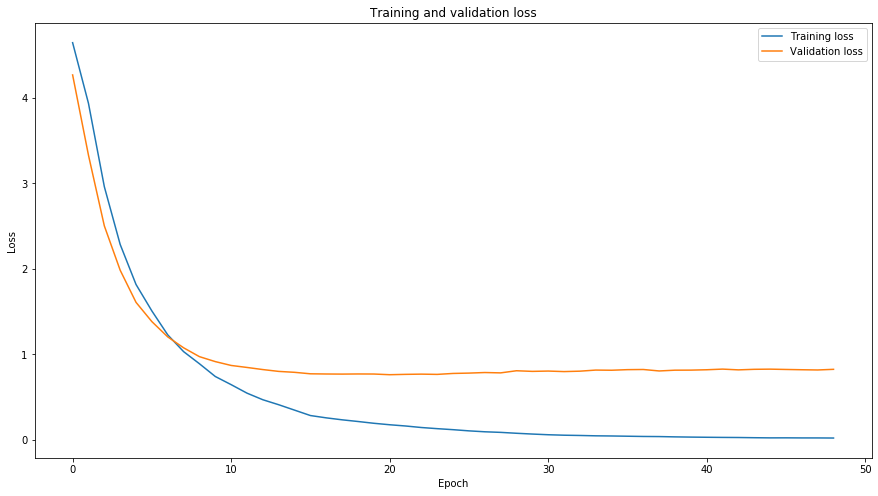

In [12]:
x = [epoch for epoch in range(len(train_loss_history))]
plt.figure(figsize=(15, 8))

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and validation loss')

plt.plot(x, train_loss_history, label='Training loss')
plt.plot(x, val_loss_history, label='Validation loss')

plt.legend()

plt.show()

In [13]:
argmin_val = np.argmin(val_loss_history)
print('Least validation loss: {} in epoch {}'.format(val_loss_history[argmin_val], argmin_val))

Least validation loss: 0.7630091699009592 in epoch 20
